# Прогнозируем задержки самолётов


В этом домашнем задании вы будете работать с задачей про задержки самолётов.  На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.

## Импорт библиотек, установка констант

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import roc_auc_score

In [2]:
RANDOM_STATE = 111
DATASET_PATH = 'https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/flight_delays_train.csv'

## Загрузка и обзор данных

In [3]:
data = pd.read_csv(DATASET_PATH)

In [4]:
data.sample(5)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
59766,c-3,c-14,c-2,942,WN,LAS,OKC,987,N
45334,c-4,c-8,c-5,1904,DL,BDL,ATL,859,N
54922,c-8,c-7,c-1,1920,OO,TYS,ORD,475,N
92068,c-11,c-24,c-4,1515,WN,PHX,ABQ,328,N
22849,c-4,c-23,c-6,1648,DH,GSO,IAD,239,N


## Вопрос для Quiz

Сколько числовых столбцов в данных?

In [16]:
data.dtypes.value_counts()[1]

2

## Обучение моделей

Разбейте данные
* на матрицу объект признак `X`, содержащую только числовые столбцы `DepTime`, `Distance`
* вектор с целевой переменной `y`, равный столбцу `dep_delayed_15min`, переведенном в 0 и 1 по правилу: 'Y' - 1, 'N' - 0.

In [17]:
X = data[['DepTime', 'Distance']]
y = data['dep_delayed_15min'].map({'Y' : 1, 'N' : 0})

In [20]:
y.value_counts()

0    80956
1    19044
Name: dep_delayed_15min, dtype: int64

Обучите по кросс-валидации с тремя фолдами и метрикой *ROC-AUC* (`scoring='roc_auc'`) три модели с гиперпараметрами по умолчанию:
* решающее дерево
* случайный лес
* градиентный бустинг

Выведите на экран среднее качество по кросс-валидации каждой из моделей.

In [34]:
from tqdm import tqdm

In [25]:
tree_cross_score = cross_val_score(DecisionTreeClassifier(random_state=RANDOM_STATE), X, y, scoring='roc_auc').mean()
tree_cross_score 

0.580212259539487

In [36]:
forest_cross_score = cross_val_score(RandomForestClassifier(random_state=RANDOM_STATE), X, y, scoring='roc_auc', n_jobs=-1).mean()
forest_cross_score 

0.6792312918703598

In [29]:
boost_cross_score = cross_val_score(GradientBoostingClassifier(random_state=RANDOM_STATE), X, y, scoring='roc_auc', n_jobs=-1).mean()
boost_cross_score 

0.6999063030069326

## Вопрос для Quiz

какой алгоритм показал наилучшее качество?

Ответ: GradientBoosting

Выведите *bias* и *variance* каждой из моделей при помощи `bias_variance_decomp` из библиотеки `mlxtend`. Функция на вход ожидает получения тренировочных и тестовых данных, поэтому разобъем все данные на train и test.

Для ускорения вычислений
* возьмите только первые 1000 строк из тренировочных данных (`Xtrain[:1000], ytrain[:1000]`)
* поставьте `num_rounds = 50` в функции `bias_variance_decomp`

И не забудьте перевести `pd.dataframe` в `np.array` - так как библиотека умеет работать только с этим типом данных (`Xtrain.values` и так для всех объектов).

In [39]:
# !pip install mlxtend --upgrade

In [38]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [44]:
from mlxtend.evaluate import bias_variance_decomp
avg_mse, avg_bias, avg_var = bias_variance_decomp(DecisionTreeClassifier(), Xtrain[:1000].values, ytrain[:1000].values,
                                                  Xtest.values, ytest.values, loss = 'mse',
                                                  random_seed=np.random.seed(RANDOM_STATE), num_rounds=50)

print('Loss_tree:', avg_mse.round(4))
print('Bias_tree:', avg_bias.round(3))
print('Variance_tree:', avg_var.round(3))

Loss_tree: 0.2969
Bias_tree: 0.177
Variance_tree: 0.12


In [45]:
from mlxtend.evaluate import bias_variance_decomp
avg_mse, avg_bias, avg_var = bias_variance_decomp(RandomForestClassifier(random_state=RANDOM_STATE), Xtrain[:1000].values, ytrain[:1000].values,
                                                  Xtest.values, ytest.values, loss = 'mse',
                                                  random_seed=np.random.seed(RANDOM_STATE), num_rounds=50)

print('Loss_forest:', avg_mse.round(4))
print('Bias_forest:', avg_bias.round(3))
print('Variance_forest:', avg_var.round(3))

Loss_forest: 0.2447
Bias_forest: 0.184
Variance_forest: 0.061


In [47]:
from mlxtend.evaluate import bias_variance_decomp
avg_mse, avg_bias, avg_var = bias_variance_decomp(GradientBoostingClassifier(random_state=RANDOM_STATE), Xtrain[:1000].values, ytrain[:1000].values,
                                                  Xtest.values, ytest.values, loss = 'mse',
                                                  random_seed=np.random.seed(RANDOM_STATE), num_rounds=50)

print('Loss_boost:', avg_mse.round(4))
print('Bias_boost:', avg_bias.round(3))
print('Variance_boost:', avg_var.round(3))

Loss_boost: 0.2151
Bias_boost: 0.17
Variance_boost: 0.045


## Вопрос для Quiz

какой алгоритм с гиперпараметрами по умолчанию имеет наименьшее смещение?

## Подбор гиперпараметров

Напомним, как мы действуем при подборе гиперпараметров:
* разбиваем данные на *train* и *test*
* на train по кросс-валидации при помощи `GridSearchCV` ищем наилучшие гиперпараметры модели
* оцениваем качество модели с наилучшими гиперпараметрами на *test*

Будем использовать 3 фолда при кросс-валидации, а метрику - *ROC-AUC* (`scoring='roc_auc'`).


Далее везде можно обучать модель на первых 10000 строк из обучающей выборки (так как всего два признака).

### 1. Подберите гиперпараметры для решающего дерева:
* `max_depth` (обязательно)
* `max_features` (обязательно)
* `criterion` (по желанию)
* `min_samples_split` (по желанию)
* `min_samples_leaf` (по желанию)

Диапазоны поиска гиперпараметров выбирайте самостоятельно.

Добейтесь качества *ROC-AUC* $>0.65$ на кросс-валидации.

In [50]:
param = {'max_depth':range(2, 20, 1),
         'max_features' : range(1,10) 
         }

gs_tree = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), param_grid=param, scoring='roc_auc', n_jobs=-1, cv=5)
gs_tree.fit(Xtrain, ytrain)

print(gs_tree.best_estimator_)
print(gs_tree.best_params_)
print(gs_tree.best_score_)

DecisionTreeClassifier(max_depth=5, max_features=2, random_state=111)
{'max_depth': 5, 'max_features': 2}
0.6931446389109708


Выведите *ROC-AUC* на тесте.

In [54]:
roc_auc_score(ytest, gs_tree.best_estimator_.predict(Xtest))

0.5367317909947196

### 2. Подберите гиперпараметры для случайного леса:
* `n_estimators` (обязательно)
* `max_depth` (обязательно)
* `max_features` (по желанию)
* `criterion` (по желанию)
* `min_samples_split` (по желанию)
* `min_samples_leaf` (по желанию)

Диапазоны поиска гиперпараметров выбирайте самостоятельно.

Добейтесь качества *ROC-AUC* $>0.65$ на кросс-валидации.

In [56]:
param = {'max_depth':range(2, 20, 1),
         'n_estimators' : range(1,25) 
         }

gs_forest = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), param_grid=param, scoring='roc_auc', n_jobs=-1, cv=5)
gs_forest.fit(Xtrain[:10000], ytrain[:10000])

print(gs_forest.best_estimator_)
print(gs_forest.best_params_)
print(gs_forest.best_score_)

RandomForestClassifier(max_depth=5, n_estimators=22, random_state=111)
{'max_depth': 5, 'n_estimators': 22}
0.7014766914987419


Теперь обучите на **всех** тренировочных данных случайный лес с лучшими  
найденными гиперпараметрами и выведите *ROC-AUC* на тесте.

In [57]:
forest =gs_forest.best_estimator_.fit(Xtrain, ytrain)
roc_auc_score(ytest, forest.predict(Xtest))

0.5038639615454991

### 3. Подберите гиперпараметры для градиентного бустинга:
* `n_estimators` (обязательно)
* `max_depth` (обязательно)
* `max_features` (по желанию)
* `criterion` (по желанию)
* `min_samples_split` (по желанию)
* `min_samples_leaf` (по желанию)

Диапазоны поиска гиперпараметров выбирайте самостоятельно.

Добейтесь качества *ROC-AUC* $>0.65$ на кросс-валидации.

In [58]:
param = {'max_depth':range(2, 20, 1),
         'n_estimators' : range(1,25) 
         }

gs_boost = GridSearchCV(GradientBoostingClassifier(random_state=RANDOM_STATE), param_grid=param, scoring='roc_auc', n_jobs=-1, cv=5)
gs_boost.fit(Xtrain[:10000], ytrain[:10000])

print(gs_boost.best_estimator_)
print(gs_boost.best_params_)
print(gs_boost.best_score_)

GradientBoostingClassifier(max_depth=4, n_estimators=18, random_state=111)
{'max_depth': 4, 'n_estimators': 18}
0.7004881327564367


Теперь обучите на **всех** тренировочных данных градиентный бустинг с лучшими  
найденными гиперпараметрами и выведите *ROC-AUC* на тесте.

In [59]:
boost =gs_forest.best_estimator_.fit(Xtrain, ytrain)
roc_auc_score(ytest, boost.predict(Xtest))

0.5038639615454991

Теперь поставьте `learning_rate = 0.01` (в десять раз меньше, чем по умолчанию) и увеличьте найденное число деревьев в 10 раз.

С этими изменениями обучите бустинг на трейне и выведите качество на тесте.

In [60]:
boost = GradientBoostingClassifier(max_depth=4, n_estimators=180, random_state=111, learning_rate=0.01)
boost.fit(Xtrain, ytrain)
roc_auc_score(ytest, boost.predict(Xtest))

0.5110096063699525

## Вопрос для Quiz

Есть ли алгоритм, который на тестовых данных показывает качество, значительно превышающее результаты других алгоритмов? (более чем на 0.1 десятую)

**Ответ:** Нет

## Размышления

Мы использовали для обучения очень много объектов и очень мало признаков, поэтому ансамбли моделей не смогли себя показать в полную мощь. Если задействовать больше характеристик полета, то и качество моделей может стать выше.

# Улучшение модели

Мы выкинули очень много колонок из начальной таблицы, но, возможно, они полезны для наших моделей.

Попробуем улучшить модель, использовав другие признаки.

In [61]:
data['dep_delayed_15min'] = data['dep_delayed_15min'].map({'Y' : 1, 'N' : 0})

Обработаем колонку месяц, оставив в ней только число - номер месяца.

Посмотрим на среднее количество задержек в каждом месяце.

In [63]:
data['Month'] = data['Month'].apply(lambda x: int(x.split('-')[1]))

print('average:', data['dep_delayed_15min'].mean())

data.groupby('Month')['dep_delayed_15min'].mean()

average: 0.19044


Month
1     0.190588
2     0.177406
3     0.194997
4     0.155328
5     0.153693
6     0.221892
7     0.238112
8     0.201925
9     0.156683
10    0.178584
11    0.170824
12    0.241258
Name: dep_delayed_15min, dtype: float64

Мы видим, что в некоторые месяцы (7 и 12) задержек довольно много, а в какие-то месяцы наоборот меньше. Так что признак может пригодиться!

В данных также есть интересный признак `UniqueCarrier` - это код авиакомпании-перевозчика.

Давайте посмотрим, связаны ли как-то задержки самолетов с авиакомпанией. Для этого выведем среднее число задержек и количество рейсов по каждой авиакомпании.

In [64]:
print('average:', data['dep_delayed_15min'].mean())

data.groupby('UniqueCarrier').agg({"dep_delayed_15min": ["mean", "count"]})

average: 0.19044


dep_delayed_15min       
                           mean  count
UniqueCarrier                         
AA                     0.187938   9418
AQ                     0.076923    234
AS                     0.243474   2222
B6                     0.213819   1838
CO                     0.181818   4334
DH                     0.161491    966
DL                     0.168922   8128
EV                     0.275318   3930
F9                     0.155070   1006
FL                     0.242185   3039
HA                     0.043307    762
HP                     0.142235   1378
MQ                     0.194545   7443
NW                     0.167890   6403
OH                     0.175882   4594
OO                     0.172801   7390
TZ                     0.143498    446
UA                     0.192263   6876
US                     0.167387   6482
WN                     0.213433  15082
XE                     0.173869   5901
YV                     0.224624   2128

Мы видим, что некоторые перевозчики довольно часто задерживают рейсы, а некоторые почти не задерживают. То есть знание об авиакомпании важно!


Код авиакомпании - это категориальный признак. В начале курса мы немного говорили про то, как можно кодировать такие признаки - вот [ссылка на соответствующий урок](https://stepik.org/lesson/806464/step/4?unit=809640).

Подход называется OneHot encoding. Напомним, в чем он состоит:
* мы создаем столько же колонок, сколько различных категорий в столбце
* далее для объекта ставим 1 в ту колонку, к категории которой он относится, а во все остальные колонки ставим 0

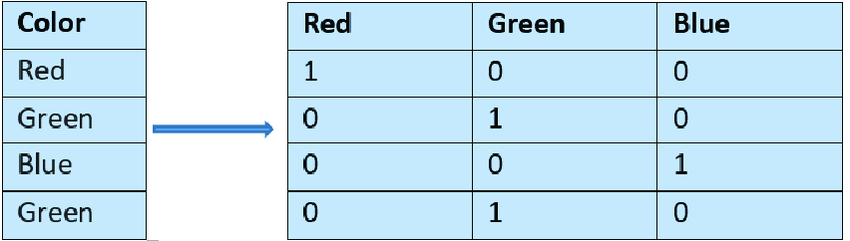

Заметим, что сумма значений в каждой строке равна 1 - то есть получили линейно-зависимые столбцы. Поэтому на практике создают на 1 колонку меньше, чем планировалось, чтобы избежать линейной зависимости.

Закодируем столбец `UniqueCarrier` при помощи OneHot encoding. В pandas этот метод называется get_dummies.

In [65]:
X = data[['Month','UniqueCarrier','DepTime','Distance']]
y = data['dep_delayed_15min']

X = pd.get_dummies(X, columns=['UniqueCarrier'], drop_first=True) # drop_first=True - выкидываем один столбец, чтобы избежать линейной зависимости
X.head()

,Month,DepTime,Distance,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DH,UniqueCarrier_DL,UniqueCarrier_EV,...,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_TZ,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV
0,8,1934,732,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,1548,834,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,9,1422,416,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,11,1015,872,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,10,1828,423,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [66]:
print('Decision Tree:', cross_val_score(DecisionTreeClassifier(), X, y, cv=3, scoring='roc_auc').mean())
print('Random Forest:', cross_val_score(RandomForestClassifier(), X, y, cv=3, scoring='roc_auc').mean())
print('Gradient Boosting:', cross_val_score(GradientBoostingClassifier(), X, y, cv=3, scoring='roc_auc').mean())

Decision Tree: 0.5813778093648567
Random Forest: 0.6952179216088199
Gradient Boosting: 0.7129768851023098


Базовые модели показывают результаты по кросс-валидации чуть лучше! Ура!

Теперь вам необходимо подобрать оптимальные гиперпараметры модели так же, как вы делали в заданиях выше.

Так как информации о каждой авиакомпании не так много, то здесь для обучения лучше использовать все тренировочные данные, а не только первые 10000 строк.

In [67]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

### Подберите оптимальные гиперпараметры для Decision Tree.

In [68]:
param = {'max_depth':range(2, 20, 1),
         'max_features' : range(1,10) 
         }

gs_tree = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), param_grid=param, scoring='roc_auc', n_jobs=-1, cv=5)
gs_tree.fit(Xtrain, ytrain)

print(gs_tree.best_estimator_)
print(gs_tree.best_params_)
print(gs_tree.best_score_)

DecisionTreeClassifier(max_depth=10, max_features=8, random_state=111)
{'max_depth': 10, 'max_features': 8}
0.6926915917567419


Теперь обучите на **всех** тренировочных данных случайный лес с лучшими  
найденными гиперпараметрами и выведите *ROC-AUC* на тесте.

In [69]:
roc_auc_score(ytest, gs_tree.best_estimator_.predict(Xtest))

0.5317067957117009

### Подберите оптимальные гиперпараметры для Random Forest.

In [70]:
param = {'max_depth':range(2, 20, 1),
         'n_estimators' : range(1,25) 
         }

gs_forest = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), param_grid=param, scoring='roc_auc', n_jobs=-1, cv=5)
gs_forest.fit(Xtrain[:10000], ytrain[:10000])

print(gs_forest.best_estimator_)
print(gs_forest.best_params_)
print(gs_forest.best_score_)

RandomForestClassifier(max_depth=8, n_estimators=24, random_state=111)
{'max_depth': 8, 'n_estimators': 24}
0.6978287615529494


Теперь обучите на **всех** тренировочных данных случайный лес с лучшими  
найденными гиперпараметрами и выведите *ROC-AUC* на тесте.

In [71]:
forest =gs_forest.best_estimator_.fit(Xtrain, ytrain)
roc_auc_score(ytest, forest.predict(Xtest))

0.505353076589476

### Подберите оптимальные гиперпараметры для Gradient boosting.

Чтобы сверить часы с составителями задания, подберите оптимальные гиперпараметры бустинга:
* задайте n_estimators = 70
* ищите max_depth в диапазоне от 10 до 20 не включительно с шагом 3

In [72]:
param = {'max_depth':range(10, 20, 3),
         }

gs_boost = GridSearchCV(GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=70), param_grid=param, scoring='roc_auc', n_jobs=-1, cv=5)
gs_boost.fit(Xtrain, ytrain)

print(gs_boost.best_estimator_)
print(gs_boost.best_params_)
print(gs_boost.best_score_)

GradientBoostingClassifier(max_depth=10, n_estimators=70, random_state=111)
{'max_depth': 10}
0.715870811883878


Теперь обучите на **всех** тренировочных данных градиентный бустинг с лучшими  
найденными гиперпараметрами и выведите *ROC-AUC* на тесте.

In [73]:
boost = GradientBoostingClassifier(max_depth=4, n_estimators=70, random_state=111)
boost.fit(Xtrain, ytrain)
roc_auc_score(ytest, boost.predict(Xtest))

0.5318369923646342

Посмотрим на важность признаков у полученного бустинга.

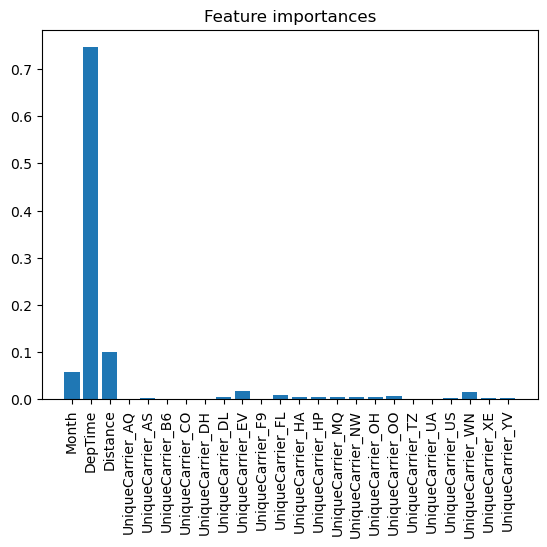

In [74]:
# в коде model - это модель (если назвали по-другому, то в этом кусочке измените model на свое название)
import matplotlib.pyplot as plt

importances = boost.feature_importances_
indices = np.argsort(importances)

plt.figure()
plt.title("Feature importances")
plt.bar(range(len(boost.feature_importances_)), boost.feature_importances_)
plt.xticks(range(len(boost.feature_importances_)), X.columns, rotation='vertical')
plt.show()

## Вопрос для Quiz

Какой признак оказался самым важным для градиентного бустинга?

**Ответ:** DepTime